In [20]:
import numpy as np
import gymnasium as gym
from matplotlib import pyplot as plt

In [21]:
# Cell 2: Q-Learning Agent and Helper Functions

"""

Creating the frozen lake environment using gymnasium

there are 2 different maps, one for the 4x4 and one for the 8x8 grid. You can also create a custom map by changing the description parameter to a list of strings.

S = starting point, safe
F = floor, safe
H = spill pits, terminal, no reward
G = target shelf goal, terminal, reward +1

Im also adding a small step penality to make the agent better at findign 
shorter pahts since it is taking quite a few steps to find the goal.

4x4 map:
S F F F
F H F H
F F F H
H F F G

8x8 map:
S F F F F F F F
F F F F F F F F
F F F H F F F F
F F F F F H F F
F F F H F F F F
F H H F F F H F
F H F F H F H F
F F F H F F F G

"""

class FrozenLakeAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float,
    ):
        """Creates a Q-learning agent for the Frozen Lake environment."""
        self.env = env
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []
    
    def get_action(self, obs: int) -> int:
        """Choose an action using the epsilon-greedy strategy."""
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[obs])

    def update(
        self, 
        obs: int,
        action: int,
        reward: float,
        terminated: bool,
        next_obs: int,
    ):
        """Update the Q-value based on experience."""
        current_q = self.q_table[obs][action]
        max_future_q = np.max(self.q_table[next_obs]) if not terminated else 0
        
        # Q-learning formula (Temporal Difference Update)
        new_q = (1 - self.lr) * current_q + self.lr * (reward + self.discount_factor * max_future_q)

        self.q_table[obs][action] = new_q
        self.training_error.append(abs(new_q - current_q))

    def decay_epsilon(self):
        """Decay epsilon after each episode."""
        self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)


def evaluate_trained_agent(agent, env, num_episodes=1000):
    """Evaluate the trained Q-learning agent without exploration."""
    successes = 0
    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action = np.argmax(agent.q_table[obs])
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if done and reward > 0:
                successes += 1
    success_rate = successes / num_episodes
    print(f"Q-learning Agent Success Rate: {success_rate:.3f} ({success_rate*100:.1f}%)")
    return success_rate

def evaluate_random_baseline(env, num_episodes=1000):
    """Evaluate random policy baseline."""
    successes = 0
    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        steps = 0
        while not done and steps < 200:
            action = env.action_space.sample()
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            steps += 1
            if done and reward > 0:
                successes += 1
    success_rate = successes / num_episodes
    print(f"Random Policy Success Rate: {success_rate:.3f} ({success_rate*100:.1f}%)")
    return success_rate

def evaluate_heuristic_baseline(env, num_episodes=1000):
    """Evaluate simple heuristic baseline (always try down/right)."""
    successes = 0
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        steps = 0
        while not done and steps < 200:
            action = 1 if steps % 2 == 0 else 2 # Down (1) or Right (2)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            steps += 1
            if done and reward > 0:
                successes += 1
    success_rate = successes / num_episodes
    print(f"Heuristic Policy Success Rate: {success_rate:.3f} ({success_rate*100:.1f}%)")
    return success_rate

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

In [22]:
# Cell 3: Visualizing the different environments and graphs 

def run_experiment(map_name: str, map_config: dict, training_params: dict, agent_params: dict = None):
    """
    Initializes the environment, trains the agent, plots results, and evaluates performance.

    Args:
        map_name: Gym map name (e.g., '4x4' or '8x8')
        map_config: kwargs for gym.make (is_slippery, success_rate, ...)
        training_params: dict containing training-level params, must include 'EPISODES'
        agent_params: dict with agent hyperparameters (learning_rate, discount_factor,
                      initial_epsilon, final_epsilon, epsilon_decay). If None, the function
                      will attempt to extract these from training_params.

    Returns:
        final_success_rate (float)
    """
    print(f"\n{'='*50}\nSTARTING EXPERIMENT FOR MAP: {map_name}\n{'='*50}")

    # 1. Environment Setup
    
    # Extracting the 4 elemtn reward schedule from the map_config
    goal_reward, hole_reward, frozen_reward, step_penalty = map_config.get("reward_schedule", (1, 0, 0, -0.01))
    
    # I created a seperate function to create the gym without the step penality
    gym_config = {
        "is_slippery": map_config['is_slippery'],
        "success_rate": map_config['success_rate'],
        "reward_schedule": (goal_reward, hole_reward, frozen_reward)
    }

    env = gym.make("FrozenLake-v1", map_name=map_name, **gym_config)

    # Determine agent parameters (backwards-compatible: extract from training_params if needed)
    if agent_params is None:
        required_agent_keys = ['learning_rate', 'discount_factor', 'initial_epsilon', 'final_epsilon', 'epsilon_decay']
        try:
            agent_params = {k: training_params[k] for k in required_agent_keys}
        except KeyError:
            raise ValueError("agent_params must be provided or training_params must contain required agent keys")

    # 2. Agent Initialization
    agent = FrozenLakeAgent(env=env, **agent_params)
    
    # 3. Training Loop
    episode_rewards = []
    episode_lengths = []

    episodes = int(training_params.get('EPISODES', 1000))
    print(f"Starting training for {episodes} episodes...")

    # Decide how many progress prints to show (up to 10 evenly spaced)
    progress_updates = min(10, max(1, episodes // 100))
    update_interval = max(1, episodes // progress_updates)

    for episode in range(episodes):
        obs, info = env.reset()
        done = False
        episode_reward = 0
        episode_length = 0

        while not done:
            action = agent.get_action(obs)
            # Taking a step in the environment with the chosen action
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Apply step penalty to encourage shorter paths
            reward += step_penalty

            agent.update(obs, action, reward, terminated, next_obs)

            episode_reward += reward
            episode_length += 1
            obs = next_obs

        agent.decay_epsilon()

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)

        # Print periodic progress: show `progress_updates` evenly-spaced updates
        if (episode + 1) % update_interval == 0 or (episode + 1) == episodes:
            recent_window = min(1000, max(10, episodes // 20))
            recent_window = min(recent_window, len(episode_rewards))
           # Current Code: Calculates AVERAGE REWARD (which can be negative)
            recent_success = sum(episode_rewards[-recent_window:]) / max(1, recent_window)
            print(f"Episode {episode + 1}: Average Reward (last {recent_window}) = {recent_success:.3f}")

    print("Training completed!")

    # 4. Visualization
    rolling_length = min(500, max(1, episodes // 20))
    fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

    fig.suptitle(f"Q-Learning Progress on {map_name} Map", fontsize=16)

    # Episode rewards
    axs[0].set_title("Episode rewards")
    reward_moving_average = get_moving_avgs(episode_rewards, rolling_length, "valid")
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
    axs[0].set_ylabel("Average Reward")
    axs[0].set_xlabel("Episode")

    # Episode lengths
    axs[1].set_title("Episode lengths")
    length_moving_average = get_moving_avgs(episode_lengths, rolling_length, "valid")
    axs[1].plot(range(len(length_moving_average)), length_moving_average)
    axs[1].set_ylabel("Average Episode Length")
    axs[1].set_xlabel("Episode")

    # Training error
    axs[2].set_title("Training Error")
    training_error_moving_average = get_moving_avgs(agent.training_error, rolling_length, "same")
    axs[2].plot(range(len(agent.training_error)), training_error_moving_average)
    axs[2].set_ylabel("Temporal Difference Error")
    axs[2].set_xlabel("Step")

    plt.tight_layout()
    plt.show()

    # 5. Evaluation and Comparison
    print("\n FINAL EVALUATION & BASELINE COMPARISON")
    print("="*60)
    final_success_rate = evaluate_trained_agent(agent, env, num_episodes=1000)

    print("\n BASELINE COMPARISONS")
    print("="*50)
    random_success = evaluate_random_baseline(env, num_episodes=1000)
    heuristic_success = evaluate_heuristic_baseline(env, num_episodes=1000)

    print("\n PERFORMANCE SUMMARY") 
    print("="*50)
    print(f"Q-learning Agent: {final_success_rate:.3f} ({final_success_rate*100:.1f}%)")
    print(f"Random Baseline: {random_success:.3f} ({random_success*100:.1f}%)")
    print(f"Heuristic Baseline: {heuristic_success:.3f} ({heuristic_success*100:.1f}%)")
    
    if random_success > 0:
        print(f"Improvement over Random: {final_success_rate/random_success:.1f}x better")
    if heuristic_success > 0:
        print(f"Improvement over Heuristic: {final_success_rate/heuristic_success:.1f}x better")
    
    print("\n Q-TABLE ANALYSIS")
    print("="*30)
    print(agent.q_table)

    env.close()
    return final_success_rate



--- Running 4x4 Experiment ---

STARTING EXPERIMENT FOR MAP: 4x4
Starting training for 20000 episodes...
Episode 2000: Average Reward (last 1000) = -0.014
Episode 4000: Average Reward (last 1000) = -0.012
Episode 6000: Average Reward (last 1000) = 0.004
Episode 8000: Average Reward (last 1000) = 0.058
Episode 10000: Average Reward (last 1000) = 0.089
Episode 12000: Average Reward (last 1000) = 0.147
Episode 14000: Average Reward (last 1000) = 0.178
Episode 16000: Average Reward (last 1000) = 0.200
Episode 18000: Average Reward (last 1000) = 0.263
Episode 20000: Average Reward (last 1000) = 0.322
Training completed!


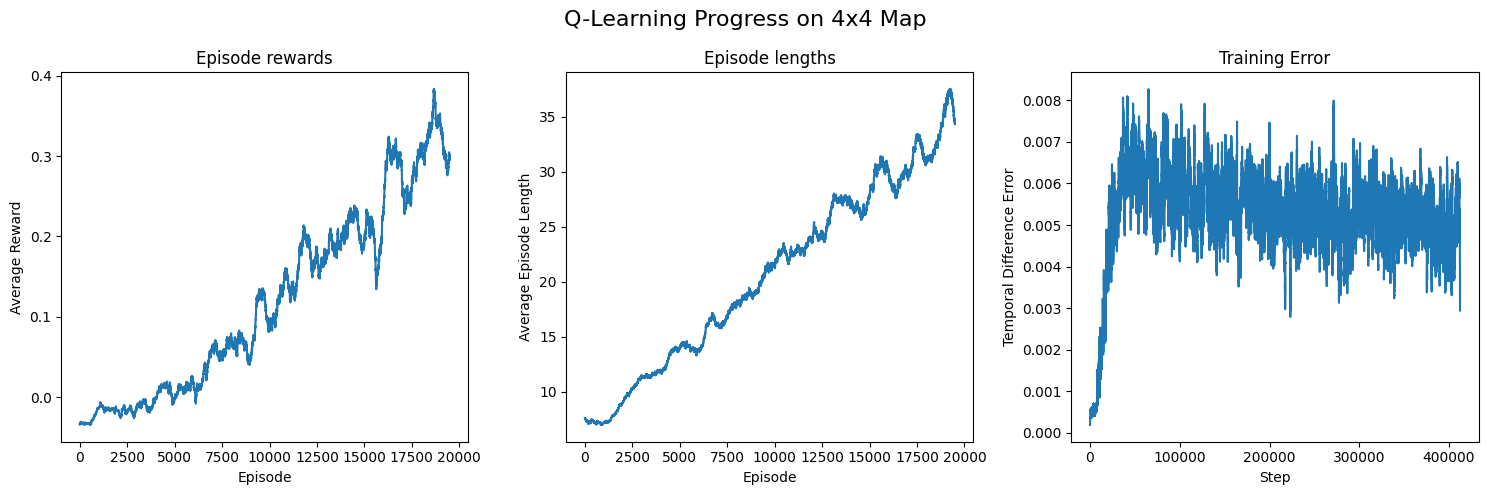


 FINAL EVALUATION & BASELINE COMPARISON
Q-learning Agent Success Rate: 0.751 (75.1%)

 BASELINE COMPARISONS
Random Policy Success Rate: 0.014 (1.4%)
Heuristic Policy Success Rate: 0.028 (2.8%)

 PERFORMANCE SUMMARY
Q-learning Agent: 0.751 (75.1%)
Random Baseline: 0.014 (1.4%)
Heuristic Baseline: 0.028 (2.8%)
Improvement over Random: 53.6x better
Improvement over Heuristic: 26.8x better

 Q-TABLE ANALYSIS
[[0.42060117 0.39214064 0.3697214  0.31176936]
 [0.20874953 0.18796907 0.18011757 0.32495397]
 [0.21913609 0.18915694 0.18997742 0.19119302]
 [0.12995147 0.14825714 0.10820832 0.17585732]
 [0.44609854 0.21420002 0.26425699 0.23969936]
 [0.         0.         0.         0.        ]
 [0.20772309 0.15156044 0.1117388  0.07474734]
 [0.         0.         0.         0.        ]
 [0.27601942 0.26189248 0.38393265 0.48976399]
 [0.23083475 0.55115582 0.37473912 0.35254155]
 [0.50462293 0.36960757 0.37160573 0.25122523]
 [0.         0.         0.         0.        ]
 [0.         0.         0. 

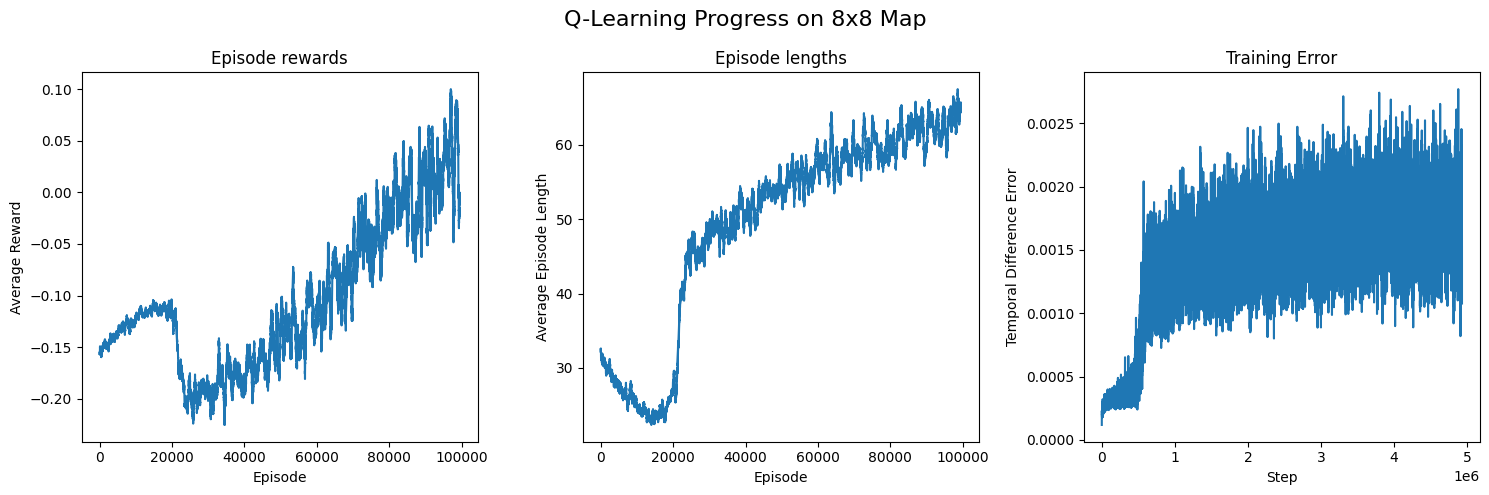


 FINAL EVALUATION & BASELINE COMPARISON
Q-learning Agent Success Rate: 0.567 (56.7%)

 BASELINE COMPARISONS
Random Policy Success Rate: 0.002 (0.2%)
Heuristic Policy Success Rate: 0.016 (1.6%)

 PERFORMANCE SUMMARY
Q-learning Agent: 0.567 (56.7%)
Random Baseline: 0.002 (0.2%)
Heuristic Baseline: 0.016 (1.6%)
Improvement over Random: 283.5x better
Improvement over Heuristic: 35.4x better

 Q-TABLE ANALYSIS
[[ 0.1266218   0.12834024  0.13082627  0.1324845 ]
 [ 0.13982776  0.14141441  0.14486091  0.14824073]
 [ 0.16758835  0.16863196  0.18211021  0.17118302]
 [ 0.19830266  0.2076813   0.21783604  0.20255975]
 [ 0.2345514   0.23461606  0.26933451  0.23626874]
 [ 0.26508557  0.26439004  0.29613354  0.26756654]
 [ 0.29018834  0.29698055  0.31700801  0.29058797]
 [ 0.30029986  0.30414224  0.31242209  0.29833483]
 [ 0.12581373  0.12512277  0.12522045  0.12701117]
 [ 0.13600607  0.13668428  0.13790707  0.14207304]
 [ 0.15194871  0.15171886  0.15462407  0.1653995 ]
 [ 0.11994     0.1585011   0.

In [23]:
# Cell 4: Configuration and Sequential Execution (Final, Corrected Logic)

"""

GLOBAL ENVIRONMENT CONFIG

"""
COMMON_ENV_CONFIG = {
    "is_slippery": True, # Stochastic environment, adds randomness to actions
    "success_rate": 1.0/3.0, # this is the probality of an action beign succesful in is_slippery mode
    "reward_schedule": (1, 0, 0, -0.005) # Goal, Hole, Frozen, step penality (Sparse Reward)
}

"""

HYPERPARAMETERS

Parameters optimized for the difficulty of each map

"""

# 4x4 is easier, can decay faster, needs fewer steps
P_4X4 = {
    'EPISODES': 20000, 
    'learning_rate': 0.1, 
    'discount_factor': 0.99, 
    'initial_epsilon': 1.0, 
    'final_epsilon': 0.05, 
    # Decay to reach 0.05 at 20k episodes
    'epsilon_decay': 0.99985
}

# 8x8 is much harder, needs more steps and slower decay
P_8X8 = {
    'EPISODES': 100000, 
    'learning_rate': 0.05, 
    'discount_factor': 0.99, 
    'initial_epsilon': 1.0, 
    'final_epsilon': 0.1, 
    # Decay to reach 0.1 at 100k episodes
    'epsilon_decay': 0.999977
}

def get_agent_params(all_params):
    """Extracts only the required hyperparameters for the FrozenLakeAgent constructor."""
    return {
        'learning_rate': all_params['learning_rate'],
        'discount_factor': all_params['discount_factor'],
        'initial_epsilon': all_params['initial_epsilon'],
        'final_epsilon': all_params['final_epsilon'],
        'epsilon_decay': all_params['epsilon_decay'],
    }

# --- RUN EXPERIMENTS ---

# Run 1: 4x4 Map 
print("\n--- Running 4x4 Experiment ---")
agent_params_4x4 = get_agent_params(P_4X4) # Extract required keys
final_rate_4x4 = run_experiment("4x4", COMMON_ENV_CONFIG, P_4X4, agent_params_4x4)

# Run 2: 8x8 Map
print("\n--- Running 8x8 Experiment ---")
agent_params_8x8 = get_agent_params(P_8X8) # Extract required keys
final_rate_8x8 = run_experiment("8x8", COMMON_ENV_CONFIG, P_8X8, agent_params_8x8)

# --- FINAL COMPARISON ---
# Both final_rate_4x4 and final_rate_8x8 are now defined
print("\n\n--- FINAL EXPERIMENT RESULTS ---")
print(f"4x4 Map Final Success Rate: {final_rate_4x4:.3f}")
print(f"8x8 Map Final Success Rate: {final_rate_8x8:.3f}")